# Experiments for extracting images of Boyd's Bird Journal into computer readable form

(See image below)

The journals are PDFs containing a series of scanned images of observations of birds. The observations are scanned handwritten notes on graph paper. There are bird species labels running down the left side of the page and date information across the top. The charts are organized by month with days of the month being column headings. There are between 2 and three months of information for each image.

Each cell has a mark indicating the presence or absence of a bird species on a given day. So there is, potentially, one mark per bird species per day. The mark on the page is typically a forward slash "/" but it can also be an "x" or a colored in block. Note that the graphs are not clean and contain other notes and stray marks. Also notice that some of the rules are incomplete or missing.

<img  src="Boyd_M_Bird_journal_section1-024.png"/>

In [1]:
%load_ext watermark
%watermark -a 'Raphael LaFrance' -i -u -v -r -g -p numpy,matplotlib,skimage

Raphael LaFrance 
last updated: 2017-10-21T13:13:12-04:00

CPython 3.6.1
IPython 6.2.1

numpy 1.13.3
matplotlib 2.1.0
skimage 0.13.1
Git hash: 1fd7ab9210c74e0518b01f78499e9446aa9a66d4
Git repo: https://github.com/rafelafrance/boyd-bird-journal.git


## Extract images from PDF files

First we need to extract individual images from the PDFs. This is easily accomplished in Linux with the command `pdfimages`. This is part of either the poppler or xpdf packages. We're using `bash` to make a directory to hold the images and then extracting the PDF images into that directory.

In [2]:
%%bash

RAW_DATA = 'raw_data'
DIRECTORY = 'images'

PDF1 = "$RAW_DATA/Boyd_M_Bird_journal_section1.pdf"
PDF2 = "$RAW_DATA/Boyd_M_Bird_journal_section2.pdf"

PREFIX1 = "$DIRECTORY/Boyd_M_Bird_journal_section1"
PREFIX2 = "$DIRECTORY/Boyd_M_Bird_journal_section2"

if [! -d "$DIRECTORY"]
then
    mkdir $DIRECTORY
    pdfimages - png $PDF1 $PREFIX1
    pdfimages - png $PDF2 $PREFIX2
fi

## Setup

We are using a fairly standard scipy stack: `numpy` & `matplotlib`. The only addition is the use of `scikit-image`.

In [3]:
# %matplotlib notebook
%matplotlib inline

import os
from itertools import product

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import cm

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# import cv2

from skimage import io
from skimage import util
from skimage.filters import sobel
from skimage.transform import hough_line, hough_line_peaks
from skimage.transform import probabilistic_hough_line, rotate

## Brief description of the Hough transform

We're using the Hough Transform to find lines in the image. It's an efficient and old algorithm for finding objects in an image. Efficient because it only scans the image once.

The basic idea of the algorithm is:

1. Set up a table of every possible line in the image. The lines are in polar form (rho, theta).
    1. Lines are limited to a given set of angles.
    1. This table will hold a count of all of the "on" pixels for the line.
1. Scan the image for "on" pixels.
1. When a pixel is "on", add one to every possible line that goes thru the pixel it.
1. After every pixel has been recorded choose all lines with a count that is greater than a given threshold.

See the [Wikipedia Page](https://en.wikipedia.org/wiki/Hough_transform) for a more detailed description.

## Define some convenience objects

#### This is the main grid class. It holds the other classes.

In [27]:
class Grid:

    def __init__(self, *, file_name=None, image=None):
        self.image = io.imread(file_name) if file_name else image

        self.edges = util.invert(self.image)

        self.horiz = Horizontal(self.edges)
        self.vert = Vertical(self.edges)

        self.cells = []
        self.row_labels = []
        self.col_labels = []
        
        self.offset = [0, 0]

    @property
    def shape(self):
        return self.edges.shape

    @property
    def width(self):
        return self.horiz.size

    @property
    def height(self):
        return self.vert.size

    def get_cells(self):
        self.cells = []
        for row, (n, s) in enumerate(zip(self.horiz.lines[:-1], self.horiz.lines[1:])):
            self.cells.append([])
            for col, (e, w) in enumerate(zip(self.vert.lines[:-1], self.vert.lines[1:])):
                self.cells[row].append(Cell(self.edges, n, s, e, w))

#### This is the base object for working with grid lines. We use if for both vertical and horizontal grid lines.

In [6]:
class GridLines:
    def __init__(self, image):
        self.image = image
        self.thetas = None
        self.angles = []
        self.dists = []
        self.lines = []
        self.threshold = 500
        self.min_distance = 40

    def find_lines(self):
        h_matrix, h_angles, h_dist = hough_line(self.image, self.thetas)

        _, self.angles, self.dists = hough_line_peaks(
            h_matrix,
            h_angles,
            h_dist,
            threshold=self.threshold,
            min_distance=self.min_distance)

    def polar2endpoints(self, angle, dist):
        if np.abs(angle) > np.pi / 4:
            x0 = 0
            x1 = self.image.shape[1]
            y0 = int(np.round(dist / np.sin(angle)))
            y1 = int(np.round((dist - x1 * np.cos(angle)) / np.sin(angle)))
        else:
            y0 = 0
            y1 = self.image.shape[0]
            x0 = int(np.round(dist / np.cos(angle)))
            x1 = int(np.round((dist - y1 * np.sin(angle)) / np.cos(angle)))

        return [x0, y0], [x1, y1] 

    def add_line(self, point1, point2):
        self.lines.append((point1, point2))
        self.sort_lines()

    def sort_lines(self):
        self.lines = sorted(self.lines, key=self.sort_key)

    def find_grid_lines(self):
        self.find_lines()

        self.lines = [self.polar2endpoints(t, r)
                      for (t, r) in zip(self.angles, self.dists)]

        self.sort_lines()

#### Given a set of near horizontal angles we can find horizontal grid lines

In [7]:
class Horizontal(GridLines):
    def __init__(self, image):
        super().__init__(image)
        self.size = image.shape[1]

    def find_grid_lines(self, add_top_edge=False, add_bottom_edge=False):
        super().find_grid_lines()

        if add_top_edge:
            self.add_line([0, 0], [self.image.shape[1], 0])

        if add_bottom_edge:
            self.add_line([0, self.image.shape[0]],
                          [self.image.shape[1], self.image.shape[0]])

    @staticmethod
    def sort_key(x):
        return x[0][1]

#### Given a set of near vertical angles we can find vertical grid lines

In [8]:
class Vertical(GridLines):
    def __init__(self, image):
        super().__init__(image)
        self.size = image.shape[0]

    def find_grid_lines(self, add_left_edge=False, add_right_edge=False):
        super().find_grid_lines()

        if add_left_edge:
            self.add_line([0, 0], [0, self.image.shape[0]])

        if add_right_edge:
            self.add_line([self.image.shape[1], 0],
                          [self.image.shape[1], self.image.shape[0]])

    @staticmethod
    def sort_key(x):
        return x[0][0]

#### Given horizontal and vertical grid lines we can define a grid cell

In [9]:
class Cell:
    row_label_threshold = 20
    col_label_threshold = 20
    col_label_crop = ((4, 4), (4, 4))

    def __init__(self, image, north=None, south=None, east=None, west=None):
        self.image = image
        self.east = east
        self.west = west
        self.north = north
        self.south = south

    def interior(self, crop=None):

        # North horizontal line
        (nx0, ny0), (nx1, ny1) = self.north

        # South horizontal line
        (sx0, sy0), (sx1, sy1) = self.south

        # East vertical line
        (ex0, ey0), (ex1, ey1) = self.east

        # West vertical line
        (wx0, wy0), (wx1, wy1) = self.west

        # Get the interior of the cell
        north = max(ny0, ny1)
        south = self.image.shape[0] - min(sy0, sy1)
        east = max(ex0, ex1)
        west = self.image.shape[1] - min(wx0, wx1)

        inside = util.crop(self.image, ((north, south), (east, west)))

        if crop:
            inside = util.crop(inside, crop)

        return inside

    def is_row_label(self):
        return np.mean(self.interior()) > self.row_label_threshold

    def is_col_label(self):
        inside = self.interior(crop=self.col_label_crop)
        return  np.mean(inside) > self.col_label_threshold

In [10]:
full_image = Grid(file_name='images/Boyd_M_Bird_journal_section1-024.png')

## Split the image into left-hand and right-hand sides

In [11]:
split = int(full_image.width / 2)

left_side = Grid(image=util.crop(full_image.image, ((0, 0), (0, split)), copy=True))

right_side = Grid(image=util.crop(full_image.image, ((0, 0), (split, 0)), copy=True))
right_side.offset[0] = split

print(full_image.shape)
print(left_side.shape)
print(right_side.shape)

(5100, 3300)
(5100, 1650)
(5100, 1650)


## Get the horizontal and vertical grid lines

As described above, we need to define a line as a threshold on the line count. However, there is a wrinkle, the images are not square with the width being the shorter dimension (3300px width x 5100px height). To accommodate this we will make two passes over the image. One for the horizontal lines and one for the vertical line.

In [12]:
near_horiz_deg = np.linspace(-2.0, 2.0, num=41)
near_vert_deg = np.linspace(88.0, 92.0, num=41)

# I'm not sure why this is required?!
near_horiz_deg, near_vert_deg = near_vert_deg, near_horiz_deg

left_side.horiz.thetas = np.deg2rad(near_horiz_deg)
left_side.vert.thetas = np.deg2rad(near_vert_deg)

print(np.rad2deg(left_side.horiz.thetas))
print(np.rad2deg(left_side.vert.thetas))

[ 88.   88.1  88.2  88.3  88.4  88.5  88.6  88.7  88.8  88.9  89.   89.1
  89.2  89.3  89.4  89.5  89.6  89.7  89.8  89.9  90.   90.1  90.2  90.3
  90.4  90.5  90.6  90.7  90.8  90.9  91.   91.1  91.2  91.3  91.4  91.5
  91.6  91.7  91.8  91.9  92. ]
[-2.  -1.9 -1.8 -1.7 -1.6 -1.5 -1.4 -1.3 -1.2 -1.1 -1.  -0.9 -0.8 -0.7 -0.6
 -0.5 -0.4 -0.3 -0.2 -0.1  0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9
  1.   1.1  1.2  1.3  1.4  1.5  1.6  1.7  1.8  1.9  2. ]


#### Find the horizontal grid lines for the left half of the image

In [13]:
left_side.horiz.threshold = left_side.width * 0.4

left_side.horiz.find_grid_lines(add_top_edge=True, add_bottom_edge=True)

print(len(left_side.horiz.angles))
print(np.rad2deg(left_side.horiz.angles))

99
[ 90.9  90.9  90.9  90.9  90.9  90.9  90.9  90.9  90.9  90.8  90.9  90.9
  90.7  90.8  90.8  90.9  90.8  90.8  90.8  90.9  90.8  90.9  90.9  90.8
  90.8  90.9  90.8  90.8  90.8  90.9  90.9  90.8  90.9  90.8  90.8  90.8
  90.8  90.8  90.9  90.8  90.9  90.8  90.9  90.9  90.8  90.9  90.8  90.9
  90.9  90.8  90.8  90.8  90.8  90.9  90.8  90.8  90.8  90.9  90.9  90.8
  90.8  90.9  90.9  90.8  90.8  90.8  90.9  90.9  90.8  90.8  90.8  90.9
  90.9  90.8  90.9  90.8  90.8  90.8  90.8  90.8  90.9  90.9  90.9  90.9
  90.7  91.   90.9  90.8  90.9  90.8  90.9  90.8  90.8  90.7  90.6  90.8
  90.8  90.8  90.1]


#### Find the vertical grid lines for the left half of the image

In [14]:
left_side.vert.threshold = left_side.height * 0.4

left_side.vert.find_grid_lines(add_left_edge=True, add_right_edge=True)

print(len(left_side.vert.angles))
print(np.rad2deg(left_side.vert.angles))

1
[ 0.3]


#### Add a vertical grid line after the first one.

We're expecting two columns of cells on the left side of the image. The cells are rather long and typically have lots of whitespace toward the right end. We expect the 1st cell to have a row number and the 2nd cell to have the bird's species identification. We are going to look at the 2nd cell to see if there is any writing in it. To help boost the signal we are going to chop the 2nd cell at a fixed width and look at that part for writing.

In [15]:
east = left_side.vert.lines[1][0][0] + 200
point1 = [east, 0]
point2 = [east, left_side.height]
left_side.vert.add_line(point1, point2)
for line in left_side.vert.lines:
    print(line)

([0, 0], [0, 5100])
([493, 0], [466, 5100])
([693, 0], [693, 5100])
([1650, 0], [1650, 5100])


#### Look at the grid from the left side of the image

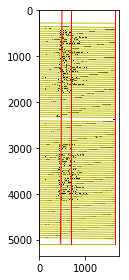

In [16]:
fig, ax = plt.subplots(figsize=(2, 4))
ax.imshow(left_side.image, cmap=plt.cm.gray)

for ((x0, y0), (x1, y1)) in left_side.horiz.lines:
    ax.plot((x0, x1), (y0, y1), '-y', linewidth=1)

for ((x0, y0), (x1, y1)) in left_side.vert.lines:
    ax.plot((x0, x1), (y0, y1), '-r', linewidth=1)

plt.tight_layout()
plt.show()

## Get grid cells in the left side of the image

We want the interior area of each cell.

In [17]:
left_side.get_cells()
print(len(left_side.cells))
print(len(left_side.cells[0]))

100
3


## Look for writing in the second cell of each row

In [18]:
left_side.row_labels = [row[1].is_row_label() for row in left_side.cells]

north ([0, 1389], [1650, 1412])
south ([0, 1434], [1650, 1460])
east ([493, 0], [466, 5100])
west ([693, 0], [693, 5100])
has label


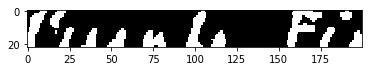

In [19]:
# @interact(row=(0, len(left_side.cells) - 1), col=(0, len(left_side.cells[0]) - 1))
def draw_row_label_interior(row, col):
    print('north', left_side.cells[row][col].north)
    print('south', left_side.cells[row][col].south)
    print('east', left_side.cells[row][col].east)
    print('west', left_side.cells[row][col].west)
    print('has label' if left_side.row_labels[row] else 'no label')
    fig, ax = plt.subplots(figsize=(6, 2))
    ax.imshow(left_side.cells[row][col].interior(), cmap=plt.cm.gray)

draw_row_label_interior(24, 1)

### Now split the right side into separate graphs

In [20]:
months = []
for r, row in enumerate(left_side.row_labels[1:], 1):

    if not left_side.row_labels[r - 1] and row:
        north = left_side.cells[r - 1][1].north[1][1]

    if left_side.row_labels[r - 1] and not row:
        south = left_side.cells[r][1].south[1][1]
        month = util.crop(
            right_side.image,
            ((north, right_side.height - south), (0, 0)), copy=True)
        months.append(Grid(image=month))
        months[-1].offset = [right_side.offset[-], north]

for month in months:
    print(month.shape)

(1502, 1650)
(1365, 1650)


In [21]:
for m, month in enumerate(months):
    month.horiz.threshold = month.width * 0.4
    month.horiz.thetas = np.deg2rad(near_horiz_deg)

    month.horiz.find_grid_lines(add_bottom_edge=True)

    month.vert.threshold = month.height * 0.4
    month.vert.thetas = np.deg2rad(near_vert_deg)

    month.vert.find_grid_lines(add_left_edge=True, add_right_edge=True)

    month.get_cells()
    month.col_labels = [cell.is_col_label() for cell in month.cells[0]]
    print('month: {} rows: {}  cols: {}'.format(m, len(month.cells), len(month.cells[0])))

month: 0 rows: 32  cols: 33
month: 1 rows: 29  cols: 32


#### Look the resulting grid

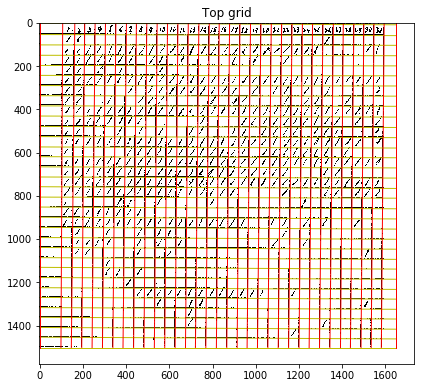

In [22]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.imshow(months[0].image, cmap=plt.cm.gray)
ax.set_title('Top grid')

for ((x0, y0), (x1, y1)) in months[0].horiz.lines:
    ax.plot((x0, x1), (y0, y1), '-y', linewidth=1)

for ((x0, y0), (x1, y1)) in months[0].vert.lines:
    ax.plot((x0, x1), (y0, y1), '-r', linewidth=1)

plt.tight_layout()
plt.show()

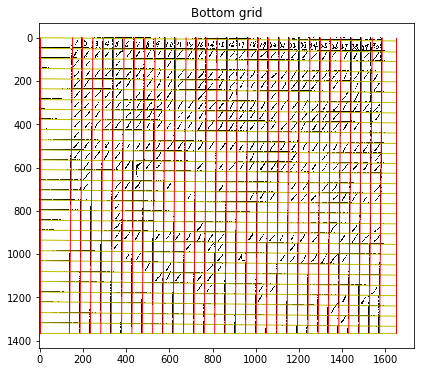

In [23]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.imshow(months[1].image, cmap=plt.cm.gray)
ax.set_title('Bottom grid')

for ((x0, y0), (x1, y1)) in months[1].horiz.lines:
    ax.plot((x0, x1), (y0, y1), '-y', linewidth=1)

for ((x0, y0), (x1, y1)) in months[1].vert.lines:
    ax.plot((x0, x1), (y0, y1), '-r', linewidth=1)

plt.tight_layout()
plt.show()

### Find column labels

mean 23.0447635135
yes


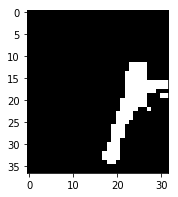

In [24]:
#@interact(mon=(0, len(months) - 1), col=(0, 35))
def draw_column_header_interior(mon, col):
    month = months[mon]
    col = -1 if col >= len(month.cells[0]) else col

    cell = month.cells[0][col]
    interior = cell.interior(crop=((4, 4), (4, 4)))

    fig, ax = plt.subplots(figsize=(3, 3))
    ax.imshow(interior, cmap=plt.cm.gray)

    mean = np.mean(interior)
    print('mean', mean)
    print('yes' if mean > 20 else '')


draw_column_header_interior(0, 1)

### Look for forward slashes in grid cells

In [25]:
forward_slashes = np.linspace(65.0, 25.0, num=161)
print(forward_slashes)
forward_slashes = np.deg2rad(forward_slashes)

[ 65.    64.75  64.5   64.25  64.    63.75  63.5   63.25  63.    62.75
  62.5   62.25  62.    61.75  61.5   61.25  61.    60.75  60.5   60.25  60.
  59.75  59.5   59.25  59.    58.75  58.5   58.25  58.    57.75  57.5
  57.25  57.    56.75  56.5   56.25  56.    55.75  55.5   55.25  55.    54.75
  54.5   54.25  54.    53.75  53.5   53.25  53.    52.75  52.5   52.25  52.
  51.75  51.5   51.25  51.    50.75  50.5   50.25  50.    49.75  49.5
  49.25  49.    48.75  48.5   48.25  48.    47.75  47.5   47.25  47.    46.75
  46.5   46.25  46.    45.75  45.5   45.25  45.    44.75  44.5   44.25  44.
  43.75  43.5   43.25  43.    42.75  42.5   42.25  42.    41.75  41.5
  41.25  41.    40.75  40.5   40.25  40.    39.75  39.5   39.25  39.    38.75
  38.5   38.25  38.    37.75  37.5   37.25  37.    36.75  36.5   36.25  36.
  35.75  35.5   35.25  35.    34.75  34.5   34.25  34.    33.75  33.5
  33.25  33.    32.75  32.5   32.25  32.    31.75  31.5   31.25  31.    30.75
  30.5   30.25  30.    29.75  29.

lines 10
yes


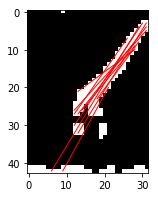

In [26]:
# @interact(mon=(0, len(months) - 1), row=(1, 40), col=(0, 35))
def draw_cell_interior(mon, row, col):
    month = months[mon]
    row = -1 if row >= len(month.cells) else row
    col = -1 if col >= len(month.cells[0]) else col

    cell = month.cells[row][col]
    interior = cell.interior()

    fig, ax = plt.subplots(figsize=(3, 3))
    ax.imshow(interior, cmap=plt.cm.gray)

    lines = probabilistic_hough_line(
        interior, line_length=15, theta=forward_slashes)
    for ((x0, y0), (x1, y1)) in lines:
        ax.plot((x0, x1), (y0, y1), '-r', linewidth=1)

    print('lines', len(lines))
    print('yes' if len(lines) else '')


draw_cell_interior(0, 1, 2)

### Stitch image parts back together to report output

# Failed experiments

- Try merging endpoints: Lines are pretty skew across the entire image. I tried to use interior points to make grid lines. This didn't really help things.

- Probabilistic Hough line: This may work for other parts of the image, like slashes, but it didn't help with either grid lines or row labels. It proved to be much slower and harder to tune for finding grid lines that span the entire image.

- OpenCV: This works, it's just less flexible for searching on a limited set of angles. The ability to pull out the horizontal, vertical, and diagonal lines separately is useful in this application. Also, OpenCV is difficult to install.